In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as n

In [5]:
from neuron import h
from neuron.units import ms, mV
h.load_file('stdrun.hoc')
nA = 1
A = 1e9

V = 1e3

In [6]:
h.steps_per_ms = 128
h.run()

Changed dt


0.0

In [7]:
def translate_loc(cell, loc):
    if loc[0] == 'axon':
            point = cell.axon(loc[2])
    elif loc[0] == 'soma':
        point = cell.soma(loc[2])
    elif loc[0] == 'dend':
        point = cell.dends[loc[1]](loc[2])
    else: assert False    
    
    return point

def simulate(cell, stimuli, recording_locs, run_time):
    stims = []
    for stimulus in stimuli:
        point = translate_loc(cell, stimulus)
        stims.append(make_IClamp(point, stimulus_params))
    
    vs = []
    for loc in recording_locs:
        point = translate_loc(cell, loc)
        vs.append(h.Vector().record(point._ref_v))
    t_recording =  h.Vector().record(h._ref_t)
        
    h.finitialize()
    h.continuerun(run_time * ms)

    out = {}
    out['t']  = n.array(t_recording)
    for i, loc in enumerate(recording_locs):
        out[loc] = n.array(vs[i])
    
    return out


def plot_simulation(out, dend_only = False):
    t = out['t']
    f,ax1 = plt.subplots()
    for key in out.keys():
        if key == 't': continue
        if dend_only and (key[0] != 'dend'): continue
        ax1.plot(t, out[key], label = '{} #{}: {:.2f}'.format(key[0], key[1], key[2]))
    ax1.legend()
    
    return f, ax1

In [8]:
def make_IClamp(loc, params):
    stimulus = h.IClamp(loc)
    stimulus.delay = params['stim_delay']
    stimulus.dur = params['stim_dur']
    stimulus.amp = params['stim_amp_nA']
    return stimulus

class Ball:
    def __init__(self,cell_id, params):
        self.cell_id = cell_id
        self.params = params
        self.init_shape() 
        self.init_biophysics()
        self.add_synapses()
        
    def add_synapses(self):
        self.syns = []
        for syn in self.params.get('synapses', []):
            point = translate_loc(self, syn['loc'])
            assert syn['type'] == 'alpha'
            synapse = h.AlphaSynapse(point)
            synapse.onset = syn['onset']
            synapse.gmax = syn['gmax']
            self.syns.append(synapse)

    def init_shape(self):
        self.soma = h.Section(name='soma', cell=self)
        self.soma.L = self.params['soma_L']
        self.soma.diam = self.params['soma_diam']
#         self.all = [self.soma]

        if self.params.get('axon', False):
            self.axon = h.Section(name='axon', cell=self)
            self.axon.L = self.params['axon_L']
            self.axon.diam = self.params['axon_diam']
            self.axon.nseg = self.params['axon_nseg']
            self.axon.connect(self.soma, 0, 0) 

        if self.params.get('dend', 0) > 0:
            self.dends = []
            assert len(self.params['dend_conns']) == self.params['dend']
            for i in range(self.params['dend']):
                self.dends.append(h.Section(name='dend_{}'.format(i)))
                self.dends[i].L = self.params['dend_L']
                self.dends[i].diam = self.params['dend_diam']
                self.dends[i].nseg = self.params['dend_nseg']
                if self.params['dend_conns'][i] == 's':
                    self.dends[i].connect(self.soma)
                else:
                    self.dends[i].connect(self.dends[self.params['dend_conns'][i]])
#                 self.all.append(self.dends[i])
        self.all = self.soma.wholetree()
    
    def init_biophysics(self ):
        
        for sec in self.all:
            sec.Ra = self.params['all_Ra'] # Axial resistance in Ohm * cm      
            sec.cm = self.params['all_cm'] # Membrane capacitance in micro Farads / cm^2
        
        if self.params.get('axon', False):
            if self.params.get('axon_hh', True): self.axon.insert('hh')
        self.soma.insert('pas')
        for seg in self.soma:
            seg.pas.g = self.params['soma_g']
            seg.pas.e = self.params['soma_e']
            pass
        
        if self.params.get('soma_hh', False):
            self.soma.insert('hh')                                                    # <-- NEW           
            for seg in self.soma:                                                     # <-- NEW
                seg.hh.gnabar = self.params['soma_hh_gnabar']  # Sodium conductance in S/cm2                   # <-- NEW
                seg.hh.gkbar = self.params['soma_hh_gkbar']  # Potassium conductance in S/cm2                # <-- NEW
                seg.hh.gl = self.params.get('soma_hh_gl', 0.0003)    # Leak conductance in S/cm2                     # <-- NEW
                seg.hh.el = self.params.get('soma_hh_el', -54.3)     # Reversal potential in mV                      # <-- NEW
    
    def __repr__(self):
        return 'Ball_{}'.format(self.cell_id)

In [9]:
def analyze_stim(data, stim, verbose = True):
    stim_start = int(h.steps_per_ms * stim.delay)
    stim_end = int(h.steps_per_ms * (stim.delay + stim.dur))
    stim_waveform = data[stim_start:stim_end]
    
    tau_m = calculate_tau(stim_waveform)
    r_i = calculate_ri(stim_waveform, stim.amp)
    
    if verbose: print("tau_m: {:.2f} secs\nr_i: {:.2f} Gohms".format(tau_m, r_i))
    
    return {'tau_m' : tau_m, 'r_i' : r_i}

def calculate_tau(stim_waveform):
    rising = (stim_waveform[-1] > stim_waveform[0])
    hi = stim_waveform.max()
    lo = stim_waveform.min()
    rng = hi - lo
    if rising: point = n.where(stim_waveform > (lo + rng*0.63))[0][0]
    else: point = n.where(stim_waveform < (lo + rng*0.37))[0][0]
    tau = point * h.dt
    return tau

def calculate_ri(stim_waveform, amplitude_nA):
    hi = stim_waveform.max()
    lo = stim_waveform.min()
    rng = hi - lo
    
    # range (rng) is in mV
    # amplitude is in nA
    # r_i is in Gohms
    r_i = rng / (amplitude_nA)
    return r_i

In [10]:
# params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
#           'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
#           'soma_hh': True,
#           'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036}
# hh_cell = Ball(0,params)

# stimulus_params = {'stim_delay' : 20, 'stim_dur' : 1, 'stim_amp_nA' : 0.01, 
#                    'stim_loc' : ('soma', 0, 0.5), 'stim_disable' : False}

# ball = Ball(0, params)
# stimulus = make_IClamp(ball.soma(0.5), stimulus_params)
# v_recording = h.Vector().record(ball.soma(0.5)._ref_v)
# t_recording =  h.Vector().record(h._ref_t)
# gnabar_recording = h.Vector().record(ball.soma(0.5).hh._ref_gna)
# gkbar_recording = h.Vector().record(ball.soma(0.5).hh._ref_gk)                 

# h.finitialize()
# h.continuerun(100 * ms)

# plt.plot(t_recording, v_recording)

# plt.plot(t_recording, gnabar_recording)
# plt.plot(t_recording, gkbar_recording)

In [11]:
def param_sweep(params, stimulus_params, param_sweeps, run_dur_ms = 20):
    
    results = {}

    for parameter in param_sweeps.keys():
        
        params_n = params.copy()
        stimulus_params_n = stimulus_params.copy()  
        
        if parameter in params_n.keys():
            param_dict_to_change = params_n
        elif parameter in stimulus_params_n.keys():
            param_dict_to_change = stimulus_params_n
        param_values = param_sweeps[parameter]
        results[parameter] = {'param_val' : [],
                              'tau_m' : [],
                              'r_i' : [],
                              'gNa' : [],
                              'gKv' : []}
        results[parameter + '_raw'] = []
        i = 0
        for param_val in param_values:
            stimulus_params_n[parameter] = param_val
    #         print(params_n)
            ball = Ball(0,params_n)
            
            if not stimulus_params_n['stim_disable']:
                stim_1Dcoord = stimulus_params_n['stim_loc'][2]
                if stimulus_params_n['stim_loc'][0] == 'soma':
                    stimulus = make_IClamp(ball.soma(stim_1Dcoord), stimulus_params_n)
                elif stimulus_params['stim_loc'][0] == 'dend':
                    dend_id = stimulus_params_n['stim_loc'][1]
                    stimulus = make_IClamp(ball.dends[dend_id](stim_1Dcoord), stimulus_params_n)
            else: 
                print("Stimulus disabled")
            
            recordings = []
            other_recordings = {}
            
            for sec in ball.all:
                recordings.append(h.Vector().record(sec(0.5)._ref_v))
                
            vec1 = h.Vector()
            vec2 = h.Vector()
            if params['soma_hh']:
                other_recordings['gk'] = (vec1.record(ball.soma(0.5).hh._ref_gk))
                other_recordings['gna'] = (vec2.record(ball.soma(0.5).hh._ref_gna))
#                 other_recordings['n_hh'] = (vec2.record(ball.soma(0.5).na_ion.ina))
#                 other_recordings['h_hh'] = (h.Vector().record(ball.soma(0.5).h_hh))
            
            t = h.Vector().record(h._ref_t)

            h.finitialize(params_n['soma_e'] * mV)
            h.continuerun(run_dur_ms * ms)

            vs = n.array(recordings[0])
            ts = n.array(t)

            if not stimulus_params_n['stim_disable']:
                res = analyze_stim(vs, stimulus, verbose = False)
            else:
                res = {'tau_m' : -1, 'r_i' : -1}
                
            tau_m = res['tau_m']
            r_i = res['r_i']
            results[parameter]['param_val'].append(param_val)
            results[parameter]['tau_m'].append(tau_m)
            results[parameter]['r_i'].append(r_i)
            
            
            raw_dict = {'t' : ts}
            j = 0
            for sec in ball.all:
                raw_dict[sec.name()] = n.array(recordings[j])
                j += 1
            if params['soma_hh']:
                for key in ['gk', 'gna']:
                    raw_dict[key] = n.array(other_recordings[key])
                
            results[parameter + '_raw'].append(raw_dict)

            i += 1
    return results

def plot_sweep(results, param, plotfunc = None):
    title = "Sweeping param: {}".format(param)
    res = results[param]
    f, ax1 = plt.subplots()
    
    ax1.set_ylabel("tau_m (sec)")
    ax1.set_xlabel("{}".format(param))
    if plotfunc is None:
        ax1.plot(res['param_val'], res['tau_m'], label='tau_m', color='blue')
    elif plotfunc == 'semilogx':
        ax1.semilogx(res['param_val'], res['tau_m'], label='tau_m', color='blue')
        
    ax2 = ax1.twinx()
    ax2.set_ylabel("r_i (Gohms)")
    if plotfunc is None:
        ax2.plot(res['param_val'], res['r_i'], label='r_i', color='red')
    elif plotfunc == 'semilogx':
        ax2.semilogx(res['param_val'], res['r_i'], label='r_i', color='red')
    ax1.legend()
    ax2.legend()
    return f
    
def plot_multiple_recordings(result_dict, title=None, plot_which = 'all'):
    time = result_dict['t']
    for key in result_dict.keys():
        if key == 't': continue
        if plot_which != 'all':
            if key not in plot_which: continue
        plt.plot(time, result_dict[key], label = key)
    plt.legend()
def plot_sweep_waveforms(param_sweeps, results, plot_conductances = False, plot_v = True, show=True):
    figs = []
    for key in param_sweeps:
        for i in range(len(param_sweeps[key])):
            f, ax1 = plt.subplots()
            if plot_v:
                ax1.plot(results[key+'_raw'][i]['t'],results[key+'_raw'][i]['Ball_0.soma'], label='voltage', color='black')
                ax1.legend()
            if plot_conductances:
                ax2 = ax1.twinx() if plot_v else ax1
                ax2.plot(results[key+'_raw'][i]['t'],results[key+'_raw'][i]['gna'], label = 'g_Na', color='red')
                ax2.plot(results[key+'_raw'][i]['t'],results[key+'_raw'][i]['gk'], label = 'g_K', color='blue')
                ax2.legend(loc = 'lower right')
            
            
            
            plt.title("Sweeping {}. Value: {:.4f}".format(key, param_sweeps[key][i]))
            if show: plt.show()
            figs.append(f)
            

### Add a single alpha excitatory synapse in the soma and then in the dendrite, progressively further away, and record at the soma. What changes?

In [33]:


synapse = {'type' : 'alpha', 'onset' : 10, 'gmax' : 0.001, 'loc':('dend',0,0.5) }

params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036,
          'axon' : False, 'axon_L': 1000, 'axon_diam' : 1, 'axon_nseg' : 20, 'axon_hh' : True,
           'dend' : 1,#4,                 # number of dendrites
           'dend_L' : 100,             # length of dendrites
           'dend_diam' : 1,            # diameter of dendrites
           'dend_nseg' : 20,
           'dend_conns' : ['s'],#['s', 's', 1, 1],
          'synapses' : [synapse]
          }

stimulus_params = {'stim_delay' : 10, 'stim_dur' : 1, 'stim_amp_nA' : 0.8, 
                   'stim_loc' : ('soma', 0, 0.5)}

dend_cell = Ball(0, params)

stimuli = []#('soma', 0, 0.5, stimulus_params) ]

recording_locs = [
    ('soma', 0, 0.5),
    ('dend', 0, 0.5),
#     ('dend', 1, 0.5),
#     ('dend', 2, 0.5),
#     ('dend', 3, 0.5)
]



(9.0, 20.0)

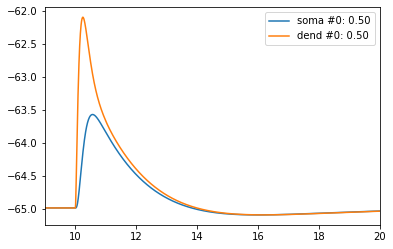

In [34]:
vs = simulate(dend_cell, stimuli, recording_locs, 100)

f, ax1 = plot_simulation(vs)
ax1.set_xlim(9, 20)

In [ ]:



synapse = {'type' : 'alpha', 'onset' : 10, 'gmax' : 0.001, 'loc':('dend',0,0.1) }

params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036,
          'axon' : False, 'axon_L': 1000, 'axon_diam' : 1, 'axon_nseg' : 20, 'axon_hh' : True,
           'dend' : 1,#4,                 # number of dendrites
           'dend_L' : 100,             # length of dendrites
           'dend_diam' : 1,            # diameter of dendrites
           'dend_nseg' : 20,
           'dend_conns' : ['s'],#['s', 's', 1, 1],
          'synapses' : [synapse]
          }

stimulus_params = {'stim_delay' : 10, 'stim_dur' : 1, 'stim_amp_nA' : 0.8, 
                   'stim_loc' : ('soma', 0, 0.5)}

dend_cell = Ball(0, params)

stimuli = []#('soma', 0, 0.5, stimulus_params) ]

recording_locs = [
    ('soma', 0, 0.5),
    ('dend', 0, 0.5),
#     ('dend', 1, 0.5),
#     ('dend', 2, 0.5),
#     ('dend', 3, 0.5)
]



### Increase/decrease Ra

lower Ra: somatic and dendritic voltage are closer together, total voltage increase is smaller

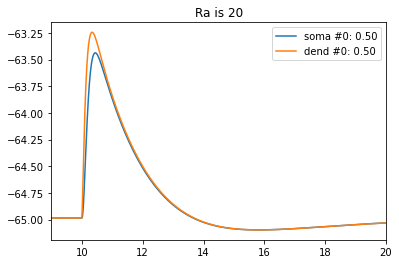

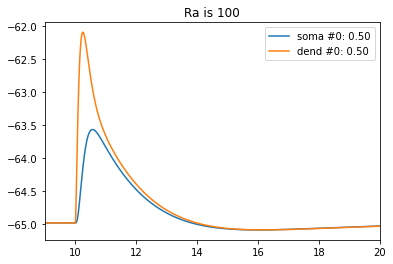

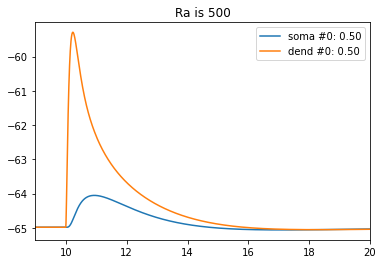

In [53]:
for new_ra in [20, 100, 500]:
    params_ra = params.copy()
    params_ra['all_Ra'] = new_ra
    dend_cell = Ball(0,params_ra)

    vs = simulate(dend_cell, stimuli, recording_locs, 100)

    f, ax1 = plot_simulation(vs)
    ax1.set_xlim(9, 20)
    plt.title("Ra is {}".format(new_ra))
    plt.show()

### Increase/decrease Cm


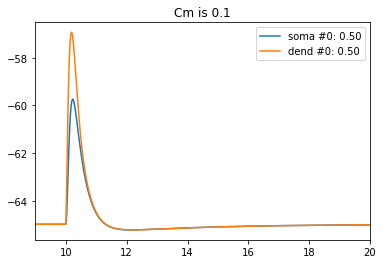

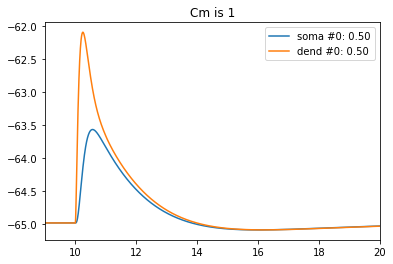

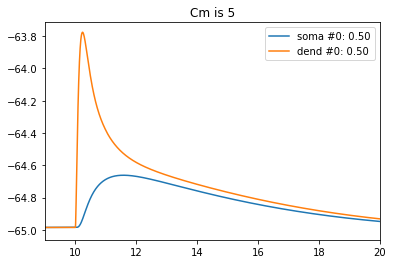

In [54]:
for new_cm in [0.1, 1, 5]:
    params_ra = params.copy()
    params_ra['all_cm'] = new_cm
    dend_cell = Ball(0,params_ra)

    vs = simulate(dend_cell, stimuli, recording_locs, 100)

    f, ax1 = plot_simulation(vs)
    ax1.set_xlim(9, 20)
    plt.title("Cm is {}".format(new_cm))
    plt.show()

### Change Rm

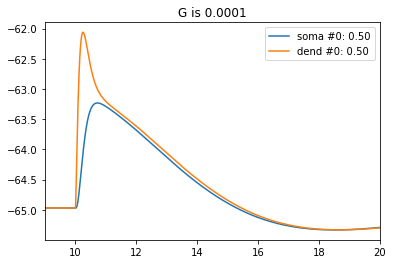

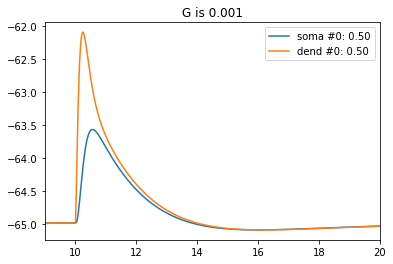

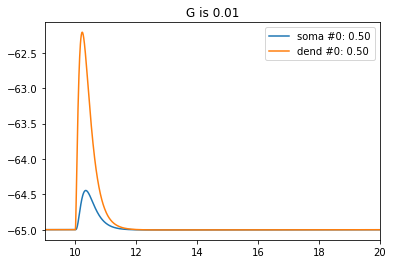

In [56]:
for new_rm in [0.0001, 0.001, 0.01]:
    params_ra = params.copy()
    params_ra['soma_g'] = new_rm
    dend_cell = Ball(0,params_ra)

    vs = simulate(dend_cell, stimuli, recording_locs, 100)

    f, ax1 = plot_simulation(vs)
    ax1.set_xlim(9, 20)
    plt.title("G is {}".format(new_rm))
    plt.show()

### Add 10 excitatory synapses and activate them with increasing temporal intervals in a soma only model (do this for passive and active models, plotting EPSP peak and AP number as a function of inter-synaptic interval). How does the temporal integration window depend on mTau?

In [81]:


synapse = {'type' : 'alpha', 'onset' : 10, 'gmax' : 0.0001, 'loc':('soma',0,0.5) }

synapses = []
synapse_dt = 1
for i in range(10):
    synapse_n = synapse.copy()
    synapse_n['onset'] = synapse['onset'] + i * synapse_dt
    synapses.append(synapse_n)

params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036,
          'axon' : False, 'axon_L': 1000, 'axon_diam' : 1, 'axon_nseg' : 20, 'axon_hh' : True,
           'dend' : 0,#4,                 # number of dendrites
           'dend_L' : 100,             # length of dendrites
           'dend_diam' : 1,            # diameter of dendrites
           'dend_nseg' : 20,
           'dend_conns' : ['s'],#['s', 's', 1, 1],
          'synapses' : synapses
          }

stimulus_params = {'stim_delay' : 10, 'stim_dur' : 1, 'stim_amp_nA' : 0.8, 
                   'stim_loc' : ('soma', 0, 0.5)}

dend_cell = Ball(0, params)

stimuli = []#('soma', 0, 0.5, stimulus_params) ]

recording_locs = [
    ('soma', 0, 0.5),
#     ('dend', 0, 0.5),
#     ('dend', 1, 0.5),
#     ('dend', 2, 0.5),
#     ('dend', 3, 0.5)
]



In [82]:
vs

{'t': array([0.00000000e+00, 7.81250000e-03, 1.56250000e-02, ...,
        9.99843750e+01, 9.99921875e+01, 1.00000000e+02]),
 ('soma',
  0,
  0.5): array([-65.        , -64.99976616, -64.99953532, ..., -65.01767165,
        -65.01758532, -65.01749921])}

In [91]:
synapse_dts = n.linspace(0.01, 1, 50)
max_epsps = []
for synapse_dt in synapse_dts:
    synapses = []
    for i in range(10):
        synapse_n = synapse.copy()
        synapse_n['onset'] = synapse['onset'] + i * synapse_dt
        synapses.append(synapse_n)
    params_n = params.copy()
    params_n['synapses'] = synapses
    dend_cell = Ball(0, params_n)
    
    vs = simulate(dend_cell, stimuli, recording_locs, 100)

#     f, ax1 = plot_simulation(vs)
    max_epsps.append(vs[('soma',0,0.5)].max())
# ax1.set_xlim(9, 20)

(-65.0, -60.0)

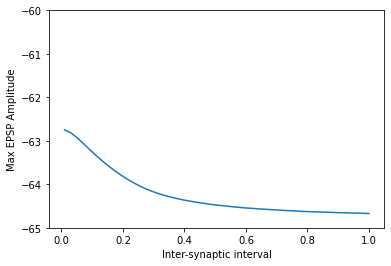

In [92]:
plt.plot(synapse_dts, max_epsps)
plt.xlabel("Inter-synaptic interval")
plt.ylabel("Max EPSP Amplitude")
plt.ylim(-65, -60)

### Repeat with larger mtau

In [96]:
synapse_dts = n.linspace(0.01, 1, 50)
max_epsps = []
for synapse_dt in synapse_dts:
    synapses = []
    for i in range(10):
        synapse_n = synapse.copy()
        synapse_n['onset'] = synapse['onset'] + i * synapse_dt
        synapses.append(synapse_n)
    params_n = params.copy()
    params_n['synapses'] = synapses
    params_n['all_cm'] = 2
    dend_cell = Ball(0, params_n)
    
    vs = simulate(dend_cell, stimuli, recording_locs, 100)

#     f, ax1 = plot_simulation(vs)
    max_epsps.append(vs[('soma',0,0.5)].max())
# ax1.set_xlim(9, 20)

(-65.0, -60.0)

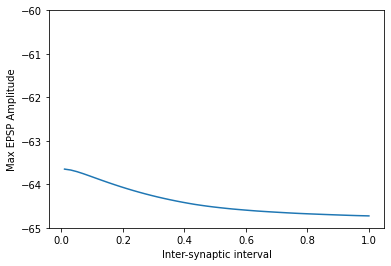

In [97]:
plt.plot(synapse_dts, max_epsps)
plt.xlabel("Inter-synaptic interval")
plt.ylabel("Max EPSP Amplitude")
plt.ylim(-65, -60)

### Repeat with smaller mtau

(-65.0, -60.0)

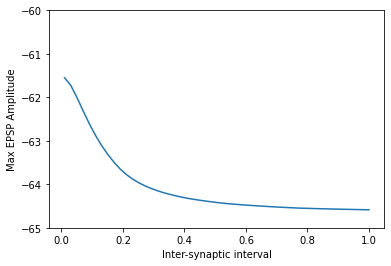

In [98]:
synapse_dts = n.linspace(0.01, 1, 50)
max_epsps = []
for synapse_dt in synapse_dts:
    synapses = []
    for i in range(10):
        synapse_n = synapse.copy()
        synapse_n['onset'] = synapse['onset'] + i * synapse_dt
        synapses.append(synapse_n)
    params_n = params.copy()
    params_n['synapses'] = synapses
    params_n['all_cm'] = 0.5
    dend_cell = Ball(0, params_n)
    
    vs = simulate(dend_cell, stimuli, recording_locs, 100)

#     f, ax1 = plot_simulation(vs)
    max_epsps.append(vs[('soma',0,0.5)].max())
# ax1.set_xlim(9, 20)
plt.plot(synapse_dts, max_epsps)
plt.xlabel("Inter-synaptic interval")
plt.ylabel("Max EPSP Amplitude")
plt.ylim(-65, -60)

### In a model with dendrites, compare the somatic EPSPs generated by 10 synapses in the same dendritic location versus 10 synapses in different dendritic branches.

#### 10 synapses on the same dendrite

Depolarization due to 10 synapses on the same dendrite is 7.3726 mV


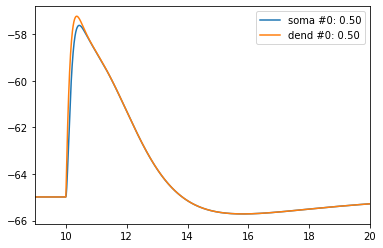

In [39]:


synapse = {'type' : 'alpha', 'onset' : 10, 'gmax' : 0.0005, 'loc':('dend',0,0.5) }

synapses = []
synapse_dt = 1
for i in range(10):
    synapse_n = synapse.copy()
    synapse_n['onset'] = synapse['onset'] + i * synapse_dt
    synapses.append(synapse_n)

params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036,
          'axon' : False, 'axon_L': 1000, 'axon_diam' : 1, 'axon_nseg' : 20, 'axon_hh' : True,
           'dend' : 10,#4,                 # number of dendrites
           'dend_L' : 10,             # length of dendrites
           'dend_diam' : 1,            # diameter of dendrites
           'dend_nseg' : 20,
           'dend_conns' : ['s']*10,#['s', 's', 1, 1],
          'synapses' : [synapse for i in range(10)]
          }

stimulus_params = {'stim_delay' : 10, 'stim_dur' : 1, 'stim_amp_nA' : 0.8, 
                   'stim_loc' : ('soma', 0, 0.5)}

dend_cell = Ball(0, params)

stimuli = []#('soma', 0, 0.5, stimulus_params) ]

recording_locs = [
    ('soma', 0, 0.5),
    ('dend', 0, 0.5),
#     ('dend', 1, 0.5),
#     ('dend', 2, 0.5),
#     ('dend', 3, 0.5)
]



vs = simulate(dend_cell, stimuli, recording_locs, 100)

f, ax1 = plot_simulation(vs)
ax1.set_xlim(9, 20)
print("Depolarization due to 10 synapses on the same dendrite is {:.4f} mV".format(vs[('soma', 0, 0.5)].max() - vs[('soma',0,0.5)][0]))

Depolarization due to 10 synapses on different dendrites is 7.5208 mV


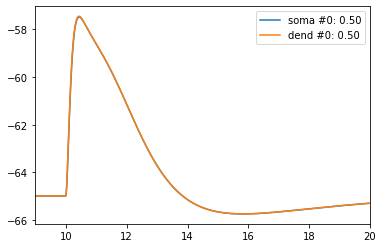

In [38]:


synapse = {'type' : 'alpha', 'onset' : 10, 'gmax' : 0.0005, 'loc':('dend',0,0.5) }

synapses = []
synapse_dt = 1
for i in range(10):
    synapse_n = synapse.copy()
    synapse_n['loc'] = ('dend', i, 0.5)
#     synapse_n['onset'] = synapse['onset'] + i * synapse_dt
    synapses.append(synapse_n)

params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036,
          'axon' : False, 'axon_L': 1000, 'axon_diam' : 1, 'axon_nseg' : 20, 'axon_hh' : True,
           'dend' : 10,#4,                 # number of dendrites
           'dend_L' : 10,             # length of dendrites
           'dend_diam' : 1,            # diameter of dendrites
           'dend_nseg' : 20,
           'dend_conns' : ['s']*10,#['s', 's', 1, 1],
          'synapses' : synapses
          }

stimulus_params = {'stim_delay' : 10, 'stim_dur' : 1, 'stim_amp_nA' : 0.8, 
                   'stim_loc' : ('soma', 0, 0.5)}

dend_cell = Ball(0, params)

stimuli = []#('soma', 0, 0.5, stimulus_params) ]

recording_locs = [
    ('soma', 0, 0.5),
    ('dend', 0, 0.5),
#     ('dend', 1, 0.5),
#     ('dend', 2, 0.5),
#     ('dend', 3, 0.5)
]



vs = simulate(dend_cell, stimuli, recording_locs, 100)

f, ax1 = plot_simulation(vs)
ax1.set_xlim(9, 20)
print("Depolarization due to 10 synapses on different dendrites is {:.4f} mV".format(vs[('soma', 0, 0.5)].max() - vs[('soma',0,0.5)][0]))

### inhibitory and excitatory synapses

In [1]:


synapses = [{'type' : 'alpha', 'onset' : 10, 'gmax' : 0.0001, 'loc':('dend',0,0.5)},
            {'type' : 'alpha', 'onset' : 20, 'gmax' : -0.0001, 'loc':('dend',0,0.5)}]



params  = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65,
          'soma_hh': True,
          'soma_hh_gnabar' : 0.12, 'soma_hh_gkbar' : 0.036,
          'axon' : False, 'axon_L': 1000, 'axon_diam' : 1, 'axon_nseg' : 20, 'axon_hh' : True,
           'dend' : 1,#4,                 # number of dendrites
           'dend_L' : 100,             # length of dendrites
           'dend_diam' : 1,            # diameter of dendrites
           'dend_nseg' : 20,
           'dend_conns' : ['s'],#['s', 's', 1, 1],
          'synapses' : synapses
          }

max_depolarizations = []
inter_synaptic_intervals = n.linspace(-5, 5, 10)
for inter_synaptic_interval in inter_synaptic_intervals:
    synapses = [{'type' : 'alpha', 'onset' : 10, 'gmax' : 0.0001, 'loc':('dend',0,0.5)},
                {'type' : 'alpha', 'onset' : 10 + inter_synaptic_interval, 'gmax' : -0.0001, 'loc':('dend',0,0.5)}]

    params['synapses'] = synapses
    
    dend_cell = Ball(0, params)

    stimuli = []

    recording_locs = [
        ('soma', 0, 0.5),
        ('dend', 0, 0.5),
    #     ('dend', 1, 0.5),
    #     ('dend', 2, 0.5),
    #     ('dend', 3, 0.5)
    ]



    vs = simulate(dend_cell, stimuli, recording_locs, 40)
    max_depolarizations.append(vs[('soma', 0, 0.5)].max())

    f, ax1 = plot_simulation(vs)
    # ax1.set_xlim(9, 20)
#     print("Depolarization due to 10 synapses on different dendrites is {:.4f} mV".format(vs[('soma', 0, 0.5)].max() - vs[('soma',0,0.5)][0]))

NameError: name 'n' is not defined

Text(0.5, 0, 'inhibitory synapse onset time (relative to exictatory onset) (ms)')

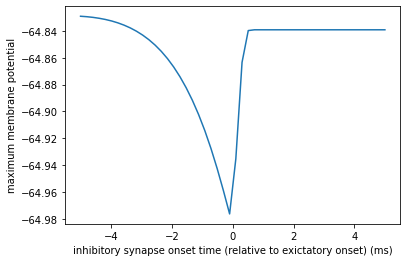

In [32]:
plt.plot(inter_synaptic_intervals,max_depolarizations)
plt.ylabel("maximum membrane potential")
plt.xlabel("inhibitory synapse onset time (relative to exictatory onset) (ms)")